<a href="https://colab.research.google.com/github/CHIN-HUA/AI/blob/main/QPA_code_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

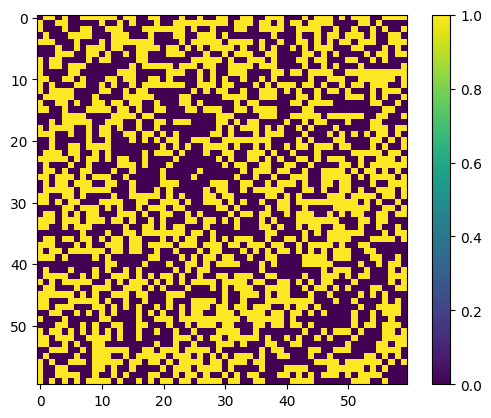

In [2]:
adjMat = np.load("adjMat.npy")     # load example Max-Cut problem
plt.imshow(adjMat)
plt.colorbar()

In [3]:
coulpingMatrix = - adjMat   # Covert problem to Ising coupling

In [39]:
# parameter chosing
numTrials = 100
numIterations = 1000   # predefined number of iterations
numSpins = coulpingMatrix.shape[0]  # number of spins (Problem size N)
adpRate = 0.05    # learning rate/step size
lamda = np.linspace(10,0,numIterations)     # coefficient of initial Hamiltonian

In [40]:
# initilization
spinVector = np.random.randint(2,size=(numSpins,numTrials))*2-1.0   # randomly initialize spin configurations
xVector = np.zeros((numSpins,numTrials))    # zero initialize classical "superposition"
momentum = np.zeros((numSpins,numTrials))    # zero initialize momentum
isingHamil = np.zeros(numTrials)    # Ising Hamiltonian
isingHamilHistory = np.zeros((numIterations,numTrials))     # Ising Hamiltonian History

In [41]:
# run
for ii in np.arange(numIterations):
    delHising = np.dot(-coulpingMatrix, spinVector)     # can be implemented experimentally by memristor crossbar array
    delHinit = xVector
    delHsystem = delHising + lamda[ii]*delHinit
    momentum = (1-adpRate)*momentum - adpRate*delHsystem    # update momentum
    momentum = np.clip(momentum,-1,1)   # clip momentum
    xVector += momentum     # update classical "superposition"
    xVector = np.clip(xVector,-1,1 )    # clip classical "superposition"
    spinVector = np.sign(xVector)
    for tt in np.arange(numTrials):
        isingHamil[tt] = - 0.5*np.dot(spinVector[:,tt].T, (coulpingMatrix @ spinVector[:,tt]))      # calculate Ising Hamiltonian
    isingHamilHistory[ii] = isingHamil      # energy tracking

(-200.0, 200.0)

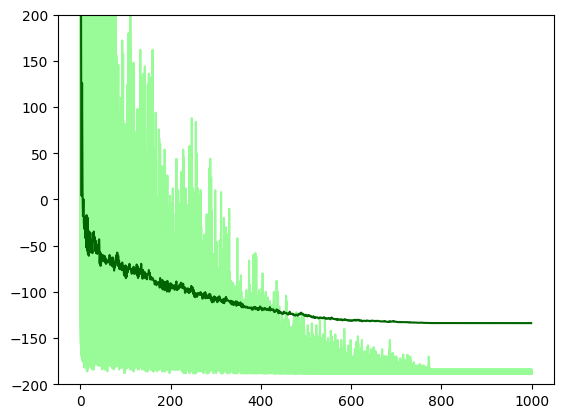

In [42]:
for tt in np.arange(numTrials):
    plt.plot(isingHamilHistory[:,tt], color = 'palegreen')
plt.plot(np.mean(isingHamilHistory,axis=1), color='darkgreen')
plt.ylim(-200,200)

In [43]:
successProbabilty = np.sum(isingHamilHistory[-1,:] == -188) / numTrials        # compare the result to a known optimal solution to get success probability
print(successProbabilty)

0.58
